# Bike Sharing Prediction - Group 3

**Description of Dataset**:
- instant: record index
- dteday : date
- hr : hour (0 to 23)
- weathersit : Weather situation
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered. This is the target to predict.


## 1. Environment Setup and Dataset Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('hour.csv', parse_dates=['dteday'], index_col=['instant'])
df.head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


## 2. Exploratory Data Analysis
### 2.1 Data types of dataset
A first view at the data types of each column proves useful in later analyses.

In [3]:
df.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

### 2.2 Missing values in each column
Now, to examine the amount of missing values in each column.

In [4]:
len(df)

17379

In [5]:
df.isnull().sum()

dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

The 5 columns representing weather data show around 100 missing values, probably due to sensor failures. One of these variables, "weathersit" is nonetheless a string, and its null values may have different causes.

### 2.3 Distribution of each column
#### 2.3.1 Categorical columns
Let's start by checking the number of unique values for the categorical variables in the dataframe.

In [6]:
df['weathersit'].value_counts(dropna=False)

Clear, Few clouds, Partly cloudy, Partly cloudy                                            11345
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                4517
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     1414
NaN                                                                                          100
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     3
Name: weathersit, dtype: int64

The entries on this column are fairly strange, since:
* Weather conditions are repeated in the same entry (for example, 'Partly cloudy' appears twice in the first entry type)
* Weather conditions can be separated by ',' but also by '+'.

It may be necessary later on to separate individual conditions and one-hot encode them. The degree of separation (whether to create a dummy variable for 'Mist + Cloudy' and another for 'Mist + Broken clouds' instead of a dummy variable for 'Mist', another one for 'Cloudy', and another one for 'Broken clouds' will be evaluated later on.

#### 2.3.2 Numerical columns
Starting with the date column:

In [7]:
print(df['dteday'].min(), df['dteday'].max())

2011-01-01 00:00:00 2012-12-31 00:00:00


Now, to observe the distribution of numerical columns in the dataset, one can begin analyzing the max, min, mean, and quartile values of each of these columns.

In [8]:
df[['hr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']].describe()

,hr,temp,atemp,hum,windspeed,cnt
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,977.000000


Further, one can also observe the distribution of each of these variables.

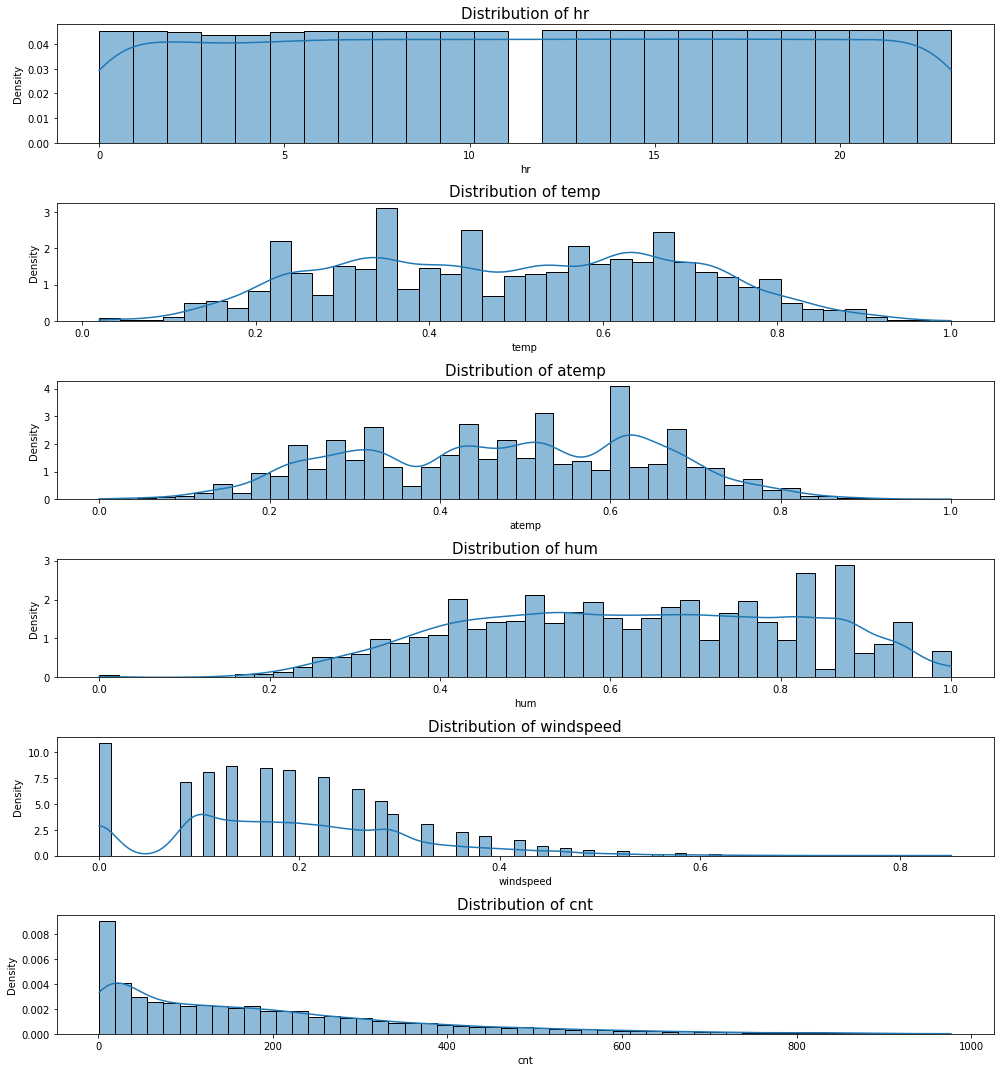

In [9]:
fields = ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
fig, axs = plt.subplots(figsize=(14, 15), ncols=1, nrows=len(fields), sharey=False)
for field, ax in zip(fields, axs):
    ax.set_title('Distribution of ' + field, fontsize=15)
    sns.histplot(df[field], ax=ax, kde=True, stat='density')
fig.tight_layout()

As a result:
* 'hr' is seen to follow a uniform distribution, with a slight low at noon.
* 'temp' and 'atemp' are very widely spread from 0.2 to 0.8, with certain inhomogeneities in the middle.
* 'hum' does not present a centered distribution, with most values above 0.5. It may make sense to normalize this distribution, and to eliminate occurrences where 'hum'=0, since there is no smooth transition towards this value, making one suspect of sensor failure.
* 'windspeed' is right-skewed, with a large peak at 0. This variable may benefit from Box-Cox normalization. Larger histogram bins may improve this representation. Why the peak at 0? Is it because a certain minimum windspeed is necessary to activate the sensor? This make sense if one thinks of a very heavy anemometer, which requires some wind to start rotating.
* The target 'cnt' is even more right-skewed, with an even larger peak at 0. There are a large number of outlier variables.

Now it follows to determine if there are significant outliers for each of these numerical columns. As well as further learning about the variables' distribution, a box-plot of each column will provide this insight.

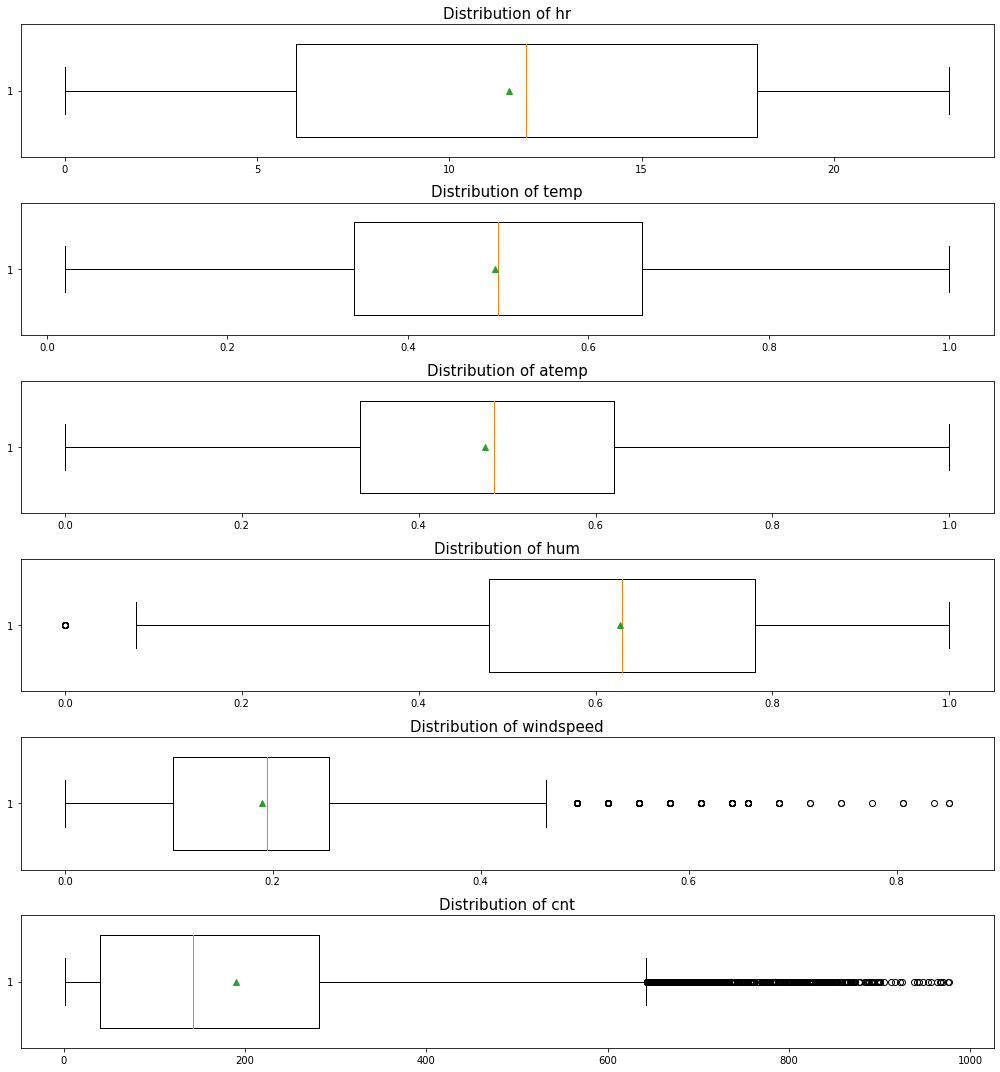

In [10]:
fields = ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
fig, axs = plt.subplots(figsize=(14, 15), ncols=1, nrows=len(fields), sharey=False)
for field, ax in zip(fields, axs):
    ax.set_title('Distribution of ' + field, fontsize=15)
    ax.boxplot(df[field].dropna().values, vert=False, widths=0.7, showmeans=True)
fig.tight_layout()

Some notes on these results:
* **hum:** As confirmed, the lack of a smooth evolution towards the peak at 'hum'=0 makes one think of outliers for this value. This is confirmed at this box-plot, where values of 'hum' below Q1 - 1.5*(Q3 - Q1) are marked as outliers.
* **windspeed:** There is a significant number of outliers beyond Q3 + 1.5*(Q3 - Q1).
* **cnt:** As previously mentioned, there is a large number of days with an extreme number of bicycle rentals. These are probably to be removed.

## 2.4 Correlations between columns
For determining:
* What columns affect most significantly on the target variable
* What columns present redundant information

It is useful to examine the correlation matrix of all columns in the dataframe.

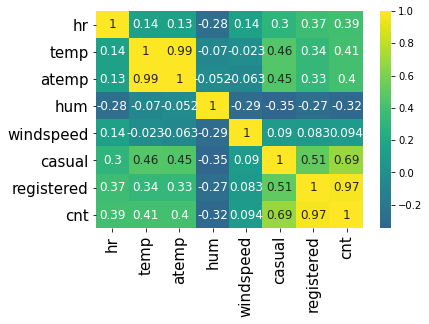

In [11]:
corr_mat = sns.heatmap(df.corr(), annot=True, cmap='viridis', center=0, annot_kws={"fontsize":12})
xtick_labels = corr_mat.get_xmajorticklabels()
ytick_labels = corr_mat.get_ymajorticklabels()
_ = corr_mat.set_xticklabels(xtick_labels, fontsize = 15)
_ = corr_mat.set_yticklabels(ytick_labels, fontsize = 15)

Insights extracted from this chart:
* 'atemp' and 'temp' are redundant
* 'casual' and 'registered' are extremely correlated with 'cnt'. This is obviously because 'cnt' = 'casual' + 'registered'
* 'hum' has a very strong negative correlation with 'cnt'
* 'temp' and 'atemp' have a strong positive correlation with 'cnt'
* 'hr' has a strong positive correlation with 'cnt'

Let's take a further look at the relations between 'hr', 'temp', 'hum', and 'windspeed' with 'cnt'.

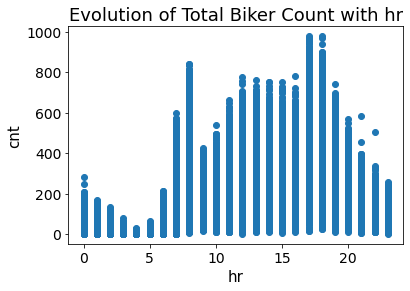

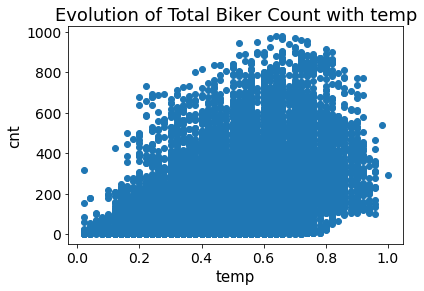

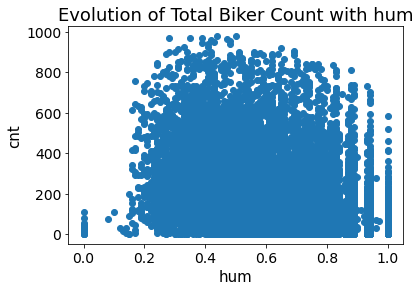

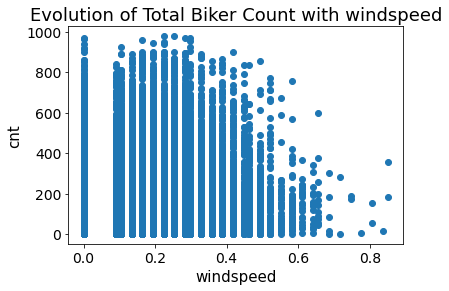

In [12]:
for x in ['hr', 'temp', 'hum', 'windspeed']:
    plt.figure()
    plt.title('Evolution of Total Biker Count with ' + x, fontsize=18)
    plt.scatter(df[x], df['cnt'])
    plt.xlabel(x, fontsize=15)
    plt.ylabel('cnt', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

The relationships between the target 'cnt' and these three variables are not as straight-forward as one would expect:
* **hr:** One can see that there is a significant peak in biker traffic in the middle of the afternoon (17:00), precisely matching the habitual hour of the commute home from the workplace. After this peak, the maximum traffic for a given hour decreases until the early morning of the next day (around 4:00), when traffic increases again. This is therefore not a monotonic relationship, although the positive correlation between both variables may make one think so.
* **temp (and atemp):** The relation between temperature and bicycle traffic is more sensible, since as temperature increases, bicycle traffic increases clearly. There is even a temperature at which the minimum recorded traffic is beyond 0.
* **hum:** The effect of humidity on traffic is harder to clarify. However, it is visible that for very low humidities, no cyclists are recorded. This makes one think that recordings in which 'hum' is 0 correspond to measurement errors that have to be removed.
* **windspeed:** If windspeed is relatively large, maximum bicycle traffic decreases. There is a very strong usage of these rental bicycles when the windspeed is 0.

## 2.5 Principal Component Analysis
To examine whether defining new features based linear combinations of original features may prove useful for the prediction, an initial PCA of the dataset might prove useful. In this case, we will focus only on the four previously examined numerical features, in the first place normalizing 'hr' in the same way as 'temp', 'hum', and 'windspeed'.

In [13]:
df['hr_minmax'] = (df['hr'] - df['hr'].min()) / (df['hr'].max() - df['hr'].min())
pca = PCA(n_components='mle')
pca.fit(df[['hr_minmax', 'temp', 'hum', 'windspeed']].dropna())

PCA(n_components='mle')

In [14]:
pca.n_components_

3

In [15]:
X_transformed = pd.DataFrame(np.eye(3))
X_original = pca.inverse_transform(X_transformed)
print('Original Feature Space: \n', X_original)

Original Feature Space: 
 [[ 1.45030439  0.63392716  0.35365478  0.27150121]
 [ 0.63126884 -0.49183984  0.60181545  0.25582605]
 [ 0.21322393  0.50005435 -0.29602211  0.44363473]]


Here, one can see how a simple PCA analysis, where the number of transformed features is automatically set, combines these four numerical variables into three. As we can see from the inverse transformation from the transformed feature space to the original space:
* **First transformed feature:** 1.45030439 * hr + 0.63392716 * temp + 0.35365478 * hum +  0.27150121 * windspeed
* **Second transformed feature:** 0.63126884 * hr - 0.49183984 * temp + 0.60181545 * hum +  0.25582605 * windspeed
* **Third transformed feature:** 0.21322393 * hr + 0.50005435 * temp - 0.29602211 * hum +  0.44363473 * windspeed

These insights might be useful later on in the study.

## 3. Data Engineering 

### 3.1 Encoding and Transforming 'dteday'
**What to do with 'dteday'?**
It makes scarce sense to use this column as is to train the model, since it simply has a single value for each day in the dataset, each day repeating 24 times, per each of the 24 hours in the day. Instead, one has to extract valuable information from the date, grouping different dates into groups that add value to our prediction. These are some possible groupings for dates that add meaning to the prediction:
* Grouping by season: Clearly, as the weather changes with the seasons, it is expected for bike rentals to vary. A snowy Washington D.C. during the winter will definitely not see as many rentals as in a hot summer day. However, one has to be careful here, since linking seasons to weather may introduce features redundant with others such as 'temp', 'hum', or 'windspeed'.
* Grouping by holiday-workday: Since during national holidays people might rent bicycles for leisure rather than for commuting to work, there may be variations in 'cnt' from holidays to workdays. Thus, one can extract information from 'dteday', by separating days into holidays (including weekends and school summer vacations, as well as national holidays) and workdays.

These groupings can be expressed in terms of two new features.

#### 3.1.1 Creating a column for each season
For this feature engineering, we first started by extracting the month for each date by using the DateTimeIndex method applied to our column dteday using the month condition

In [16]:
df['Month'] = pd.DatetimeIndex(df['dteday']).month

The second step of the creation consists of creating a dictionnary of the seasons with respect to the months extracted in the previous step. 

In [17]:
season_months = {"Winter": [1, 2, 3], "Spring": [4, 5, 6], "Summer": [7, 8, 9], "Fall": [10, 11, 12]}
for season in season_months.keys():
    df[season] = df['Month'].apply(lambda m: 1 if m in season_months[season] else 0)

df[[f for f in season_months.keys()]].head(10)

,Winter,Spring,Summer,Fall
instant,,,,
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,1,0,0,0


#### 3.1.2 Creating a column for holidays
Extracting the day of the week and defining if the day is workday or weekend

In [18]:
df['day_of_week'] = df['dteday'].dt.day_name()
df['day_of_week'].head(10)

instant
1     Saturday
2     Saturday
3     Saturday
4     Saturday
5     Saturday
6     Saturday
7     Saturday
8     Saturday
9     Saturday
10    Saturday
Name: day_of_week, dtype: object

In [19]:
weekday = {"Weekend": ["Saturday", "Sunday"], "Workday": ["Monday","Tuesday", "Wednesday", "Thursday", "Friday"]}
for day in weekday.keys():
    df[day] = df["day_of_week"].apply(lambda m: 1 if m in weekday[day] else 0)
    
df[[f for f in weekday.keys()]].head(10)

,Weekend,Workday
instant,,
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


Let's take a similar approach and define now the school holidays basing into the data from the dc public schools department
https://dcps.dc.gov/sites/default/files/dc/sites/dcps/publication/attachments/DCPS%20School%20Calendar%202011-2012.pdf


In [20]:
Summer = df[(df['dteday'] > '2011-06-14 01:00:00') & (df['dteday'] <= '2011-08-22 04:00:00')]
Winter= df[(df['dteday'] > '2011-12-22 01:00:00') & (df['dteday'] <= '2012-01-03 04:00:00')]
Thanksgiving = df[(df['dteday'] > '2011-11-24 01:00:00') & (df['dteday'] <= '2011-11-27 04:00:00')]


### 3.2 Cleaning, Encoding, and Transforming 'weathersit'
**What to do with 'weathersit'?** As seen in the previous section, this feature has 4 unique values:
* "Clear, Few clouds, Partly cloudy, Partly cloudy"
* "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
* "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"
* "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"
* NaN

It seems that multiple weather conditions have already been grouped into the same value for 'weathersit'. For instance, "Heavy Rain" and "Snow + Fog" have been placed within the same 'weathersit' category. Therefore, one can **simply one-hot encode** these 4 categories, after mapping their names into more intuitive ones and dealing with NaN values.

**How to deal with NaN values?** Two different alternative methods are considered here and are defined in the following function:
* Impute NaN values with the most frequently occurring weather condition of the corresponding month. This requires inputting column 'Month' to the user-defined function. Specified with method='most_frequent'.
* Impute NaN values based on the weather conditions of neighboring instants. Specified with method='closest_entry'.

In [21]:
def map_and_impute_weather(df, method='most_frequent'):
    #This method assumes that df has only columns 'Month' and 'weathersit'
    
    #First, rename the different values of 'weathersit' with more intuitive names
    weather_mapping = {"Clear, Few clouds, Partly cloudy, Partly cloudy": "Clear",
                       "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist": "Mist",
                       "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds": "Precipitation",
                       "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog": "Heavy Weather"}
    df[['weathersit']] = df[['weathersit']].replace(weather_mapping)
    
    if method == 'most_frequent':
        #This first method is based on imputing null values with the most common weather conditions of the month.
        
        #Create a lookup table including the most frequent weather conditions of each month
        lookup = df\
                    .groupby(by=['Month', 'weathersit'])['Month']\
                    .agg(pd.Series.count)\
                    .unstack(level=-1)
        lookup = lookup.idxmax(axis=1).rename('Most_Frequent')

        #Then, join the null rows of the original dataframe with the lookup table, to impute these values.
        df.loc[df['weathersit'].isna(), 'weathersit'] = df.loc[df['weathersit'].isna(), :].join(lookup, on='Month').drop(columns='weathersit').rename(columns={'Most_Frequent': 'weathersit'})
        
        
    if method == 'closest_entry':
        #This second method imputes null values of 'weathersit' with the values of the closest entry in time.
        df[['weathersit']] = df[['weathersit']]\
                                                .fillna(method='bfill', axis=0)\
                                                .fillna(method='ffill', axis=0)
        
    df.drop(columns='Month', inplace=True)
    return df

In [22]:
print(f"method='most_frequent' results in {map_and_impute_weather(df[['Month', 'weathersit']], method='most_frequent').isna().sum()[0]} NaN values. method='closest_entry' results in {map_and_impute_weather(df[['Month', 'weathersit']], method='closest_entry').isna().sum()[0]} NaN values.")

method='most_frequent' results in 0 NaN values. method='closest_entry' results in 0 NaN values.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Based on this function, and making use of scikit-learn's `OneHotEncoder`, we will be able later on to process this column.

In [23]:
#weathersit_pipe = Pipeline([('mapper_and_imputer', map_and_impute_weather),('weather_encoder', OneHotEncoder(sparse=False))])

### 3.3 Encoding and Transforming 'hr'
**What should be done with 'hr'?** The hour of the day, as seen previously, is significantly related with the amount of rented bicycles, with a large peak of 'cnt' in the middle of afternoon and a decrease afterwards. Three sources of information from 'hr' can be extracted:
1. One can simply normalize 'hr', such that it is within 0 and 1, and treat it as another numerical value. This may be applicable for a non-linear model, since as we have seen, the relationship between 'cnt' and 'hr' is not monotonic.
2. One can determine, for the time of the year, which hours of the day have sunlight and which do not.
3. Lastly, one can associate particular hours during weekdays to commuting to and from the workplace. In other words, one can classify hours as so-called *rush-hours*.

#### 3.3.1 Normalizing 'hr'
The min-max normalization of 'hr' is very easily done by making use of scikit-learn's `MinMaxScaler`. This will be taken into account later on.

#### 3.3.2 Creating a column specifying whether it is day
In order to define this additional column, it is necessary to import data regarding the sunset and sunset hours of Washington D.C. In this case, a table has been created from the data in https://www.worlddata.info/america/usa/sunset.php.

In [24]:
sun_movements = pd.read_csv(
                            'WashingtonDC_Sun.csv', 
                            sep='\t', 
                            header=0, 
                            parse_dates=['Sunrise', 'Sunset'])\
                    .drop(columns='Hours of daylight')
sun_movements.head()

,Month,Sunrise,Sunset
0,Januar,2021-02-24 07:23:00,2021-02-24 17:11:00
1,Februar,2021-02-24 06:57:00,2021-02-24 17:47:00
2,März,2021-02-24 07:17:00,2021-02-24 19:16:00
3,April,2021-02-24 06:29:00,2021-02-24 19:46:00
4,Mai,2021-02-24 05:53:00,2021-02-24 20:15:00


In [25]:
sun_movements['Month'] = np.arange(1, len(sun_movements) + 1)
sun_movements['Sunrise'] = sun_movements['Sunrise'].dt.hour
sun_movements['Sunset'] = sun_movements['Sunset'].dt.hour
sun_movements.head()

,Month,Sunrise,Sunset
0,1,7,17
1,2,6,17
2,3,7,19
3,4,6,19
4,5,5,20


Then, this data is incorporated by joining this table with the original dataset. For every value in 'hr', it is examined whether it is within the Sunrise-Sunset time interval. Since light is present *before* the sun rises and *after* the sun sets, this interval includes the whole hours in which the sun rises and sets.

In [26]:
df = df.merge(sun_movements, on='Month', how='left')

In [31]:
df['Daylight'] = df[['hr', 'Sunrise', 'Sunset']].apply(lambda row: 1 if (row[0] >= row[1] and row[0] <= row[2]) else 0, axis=1)
df[['hr', 'Sunrise', 'Sunset', 'Daylight']].head(20)

,hr,Sunrise,Sunset,Daylight
0,0,7,17,0
1,1,7,17,0
2,2,7,17,0
3,3,7,17,0
4,4,7,17,0
5,5,7,17,0
6,6,7,17,0
7,7,7,17,1
8,8,7,17,1
9,9,7,17,1


In [32]:
df.drop(columns=['Sunrise', 'Sunset'], inplace=True)

#### 3.3.3 Creating a column specifying whether the daily commute to work is happening
To generate this column, we will make use of the previously defined column 'Holiday', and set the new column 'Rush_Hour' to 1 if it isn't a holiday and 'hr' takes a value attributable to the daily commute. According to TripSavvy (https://www.tripsavvy.com/driving-times-from-dc-1040439), rush hour in Washington D.C. occurs from 6 a.m. to 9:30 a.m. and 3:30 p.m. to 6:30 p.m.

In [ ]:
df['Rush_Hour'] = df[['Holiday', 'hr']].apply(lambda row:
                                           1 if (row[0] == 0) and (row[1] in [6, 7, 8, 9, 15, 16, 17, 18]) else 0)
df[['hr', 'Rush_Hour']].head()

### 3.4 Cleaning, Encoding, and Transforming 'hum'
* Eliminating outliers 0
* Perhaps normalizing to center???


### 3.5 Encoding and Transforming 'windspeed'
* Eliminate large outliers
* Perhaps normalize to center??

### 3.6 Encoding and Transforming 'atemp' and 'temp'
* What possible combination of the two exists?
* Distribution seems ok

### 3.7 Encoding and Transforming 'cnt'
* Eliminate large outliers
* Apply log transformation

### 3.X Structure of Preprocessing: FIRST CREATE COLUMNS (SEASON, MONTH, HOLIDAY, DAYLIGHT, COMMUTING), THEN APPLY COLUMN TRANSFORMER!

In [33]:
3 in [3,4,5]

True